# Кластеризация

In [1]:
import warnings, numpy as np, pandas as pd
warnings.filterwarnings('ignore')

from sklearn.impute      import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline    import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics     import silhouette_score, davies_bouldin_score
from sklearn.cluster     import (AgglomerativeClustering, SpectralClustering,
                                 Birch, OPTICS, AffinityPropagation)
from sklearn.mixture     import GaussianMixture
from sklearn.ensemble    import RandomForestClassifier
import matplotlib.pyplot as plt

try:
    import hdbscan
    HDBSCAN_AVAILABLE = True
except ImportError:
    HDBSCAN_AVAILABLE = False

In [108]:
pora = pd.read_excel('data/made/pora10_ind.xlsx')
other = pd.read_excel('data/made/all_other_features.xlsx')[['settlement_name_sep', 'hhru_vacancies_count',
                                                            'POI_num', 'building_num', 'dist_to_airport_geo_km',
                                                            'airport_geo_nearest', 'type_airport', 'scheduled_service',
                                                            '1000rub_per_m2_avg', 'sale_house_count', 'set_year', 'type_airport_small']]
temp = pd.read_excel('data/made/temp_counts.xlsx')[['settlement_name_sep','min_summer_temp',
                                                    'max_winter_temp', 'max_year_temp', 'min_year_temp', 'spring_off_date',
                                                    'autumn_on_date', 'heating_days_in_year', 'amplitude']]

other_temp = pd.merge(other, temp, on = 'settlement_name_sep', how = 'left')
print(len(other_temp))
data = pd.merge(pora, other_temp, on = 'settlement_name_sep', how = 'left')
data.shape

46


(46, 150)

In [109]:
data['hhru_vacancies_count_pop'] = data['hhru_vacancies_count']/data['pop_total']
data['sale_house_count_pop'] = data['sale_house_count']/data['pop_total']

In [ ]:
'pvz_norm' - Много в Мурманской области - в остальных местаз мало (чем восточнее- тем меньше0
'revenue_per_capita' и 'profit_per_capita' - не показательны
'vacancies' - Тазовский, Харп, Аскара - очень много + Печенга, Первомайский
'grocery store_norm' - есть прям большая дифференциация
'unemployed' - есть прям большая дифференциация, много в Мурманской области
'retail_federal' - в 14-ти поселениях нет продуктовых-сетевиков (Чукотка, Красноярский край)
'emissions_all' - в целом показательно, но уж очень зашкаливают Воргашор и Северный рядом с Воркутой, Уемский недалеко от Архангельска Будет прикольно, если окажется, что из поселений с более низкой температурой люди уезжают меньше
'ecology_polygon' - свалки, есть в 12-ти поселениях
'math_ege_plus', 'russian_oge', 'russian_ege'
'additional_education' - есть дифференциация. на сколько поселение, МО, регион вкладываются в детей, мотивируют оставаться
'spendings_per_schoolar' - скорей отражает дороговизну жизни в данном месте
'libraries' - есть дифференциация
'death_rate' - смертность в трудоспособном возрасте: в архангельской и мурманской областях все плохо
'support_staff' - мед. персонал, есть дифференциация
'dentists' - есть дифференциация
'building_construction_space' - ввод жилья за эту работу
'social_share' - % соц выплат от дохода
'space_per_capita' - общая площадь жилого фонда на человека 2019 - 2024 (м2/чел)
'wage_average'
'housing_depreciation' - Средний процент износа многоквартирных домов - разное
'pop_total'
'pop_men'/'pop_total' - процент мужчин, можно отличать производственные города от стареющих
'school_salary' - просто Мурманская, Архангельская область и республика Коми очень отличаются от остальных арктических
'natural_growth' - в ЯНАО и на севере Мурманской области - плюс
'Все категории' - большая разнообразность расходов
'mean_salary', 'max_salary'
'avg_age_2023, 'avg_age_2024' - село Лешуконское (2023-2024 гг) и Карпогоры (2024г.) ср. возраст 9-10 лет (?)
'2023migration_women'
'2023migration_men'
Пангоды, Заполярный - самая большая миграция мужчин и женщин в 2023 году
'Добыча полезных ископаемых'
'Строительство'
'Спорт и досуг'
'Научная и проф. деятельность'
'Здравоохранение' - в ЯНАО все гуд
'market_access'
'Маркетплейсы'
'POI_num',
'building_num',
'dist_to_airport_geo_km',
'type_airport_small',
'scheduled_service',
'rub_for_life',
'1000rub_per_m2_avg',
'sale_house_count_pop',
'hhru_vacancies_count_pop'
'set_year'

In [101]:
features = ['pvz_norm',
'grocery store_norm',
'retail_federal',
            
'vacancies',
'unemployed',

'emissions_all',
'ecology_polygon',
            
'math_ege_plus',
'additional_education',
'spendings_per_schoolar',
'libraries',          
'support_staff',
'dentists',

            
'natural_growth',
'death_rate',
'pop_total',
'pop_men_share',
'avg_age_2023',
'avg_age_2024',

'market_access',
'Маркетплейсы',
'POI_num',


'dist_to_airport_geo_km',
'type_airport_small',
'scheduled_service',

'housing_depreciation',
'building_num',
'building_construction_space',
'space_per_capita',


'social_share',
'wage_average',
'hhru_vacancies_count_pop',
'Все категории',
'Маркетплейсы',

'Добыча полезных ископаемых',
'Строительство',
'Спорт и досуг',
'Научная и проф. деятельность',
'Здравоохранение',
'school_salary',
'min_salary',
'max_salary',
'Все отрасли',
'rub_for_life',
'1000rub_per_m2_avg',
'sale_house_count_pop',

'highway_dist',
'railway_dist',
            
'set_year',
'min_summer_temp',
'max_winter_temp',
'max_year_temp',
'min_year_temp',
'heating_days_in_year',
'amplitude']

In [102]:
import numpy as np
corr = data[features].corr()

# пары с |r| > 0.5 (без диагонали)
pairs = (corr
         .where(np.triu(np.ones_like(corr, dtype=bool), k=1))  # верхний треугольник
         .stack()                                              # Series MultiIndex (row, col)
         .abs()                                                # модуль
         .loc[lambda s: s > 0.5]                               # фильтр
         .sort_values(ascending=False))                        # по убыванию

# красивый вывод
for (c1, c2), r in pairs.items():
    print(f'{c1:<25} | {c2:<25} | {r:.3f}')

Маркетплейсы              | Маркетплейсы              | 1.000
Все отрасли               | rub_for_life              | 0.995
min_year_temp             | amplitude                 | 0.990
highway_dist              | railway_dist              | 0.985
natural_growth            | death_rate                | 0.921
Спорт и досуг             | Здравоохранение           | 0.913
Добыча полезных ископаемых | Все отрасли               | 0.901
Добыча полезных ископаемых | rub_for_life              | 0.897
wage_average              | rub_for_life              | 0.867
Здравоохранение           | Все отрасли               | 0.866
Добыча полезных ископаемых | Научная и проф. деятельность | 0.865
Спорт и досуг             | Все отрасли               | 0.858
wage_average              | Все отрасли               | 0.856
Здравоохранение           | rub_for_life              | 0.843
max_winter_temp           | min_year_temp             | 0.839
max_winter_temp           | amplitude                 | 0.819
av

In [110]:
features = [
'pvz_norm',
'grocery store_norm',
'retail_federal',
            
'vacancies',
'unemployed',

'emissions_all',
'ecology_polygon',
            
'math_ege_plus',
'additional_education',
'spendings_per_schoolar',
# 'libraries',          
# 'support_staff',
'dentists',

            
'natural_growth',
# 'death_rate',
'pop_total',
'pop_men_share',
'avg_age_2023',
# 'avg_age_2024',

# 'market_access',
'POI_num',


'dist_to_airport_geo_km',
# 'type_airport_small',
'scheduled_service',
'remote',

'housing_depreciation',
# 'building_num',
'building_construction_space',
'space_per_capita',

'social_share',
# 'wage_average',
'Все категории',
# 'Маркетплейсы',
'hhru_vacancies_count_pop',

# 'Добыча полезных ископаемых',
# 'Административная деятельность',
# 'ИТ и связь',
# 'Строительство',
# 'Спорт и досуг',
# 'Научная и проф. деятельность',
# 'Здравоохранение',
# 'school_salary',
# 'min_salary',
'max_salary',
# 'Все отрасли',
'rub_for_life',
'1000rub_per_m2_avg',
'sale_house_count_pop',
           
# 'set_year',
 
'highway_dist',
# 'railway_dist',
            
# 'min_summer_temp',
# 'max_winter_temp',
# 'max_year_temp',
# 'min_year_temp',
'heating_days_in_year',
# 'amplitude'
]

In [111]:
corr = data[features].corr()

pairs = (corr
         .where(np.triu(np.ones_like(corr, dtype=bool), k=1))  # верхний треугольник
         .stack()                                              # Series MultiIndex (row, col)
         .abs()                                                # модуль
         .loc[lambda s: s > 0.5]                               # фильтр
         .sort_values(ascending=False))                        # по убыванию

for (c1, c2), r in pairs.items():
    print(f'{c1:<25} | {c2:<25} | {r:.3f}')

social_share              | rub_for_life              | 0.737
natural_growth            | rub_for_life              | 0.685
pvz_norm                  | retail_federal            | 0.634
pvz_norm                  | hhru_vacancies_count_pop  | 0.607
natural_growth            | 1000rub_per_m2_avg        | 0.607
avg_age_2023              | 1000rub_per_m2_avg        | 0.592
math_ege_plus             | highway_dist              | 0.587
spendings_per_schoolar    | rub_for_life              | 0.587
vacancies                 | 1000rub_per_m2_avg        | 0.584
avg_age_2023              | rub_for_life              | 0.583
building_construction_space | 1000rub_per_m2_avg        | 0.566
natural_growth            | social_share              | 0.552
vacancies                 | building_construction_space | 0.549
additional_education      | dentists                  | 0.538
social_share              | max_salary                | 0.516
grocery store_norm        | math_ege_plus             | 0.505


### Пробуем разные методы кластеризации, ищем лучший
- Базовая предобработка: Обработка пропусков, масштабирование
- PCA → 90% дисперсии
- Пробуем разные методы кластеризации, выбираем лучший: Spectral Clustering
- Ищем какие признаки «главные» (Random Forst feature importance)
- Берем топ-20 признаков и кластеризируем (Spectral Clustering) заново уже по ним


ТОП-10 конфигураций по силуэту:
           algo  k       sil        db
0      Spectral  4  0.179726  1.683266
1  Aggl-average  4  0.171406  1.195774
2      Spectral  3  0.171357  1.810725
3     Aggl-ward  5  0.164036  1.683158
4      Spectral  5  0.159152  1.618510
5         Birch  4  0.159015  1.788306
6         Birch  3  0.157117  2.094967
7         Birch  5  0.156097  1.602309
8           GMM  4  0.150169  1.926861
9  Aggl-average  5  0.147610  1.083139


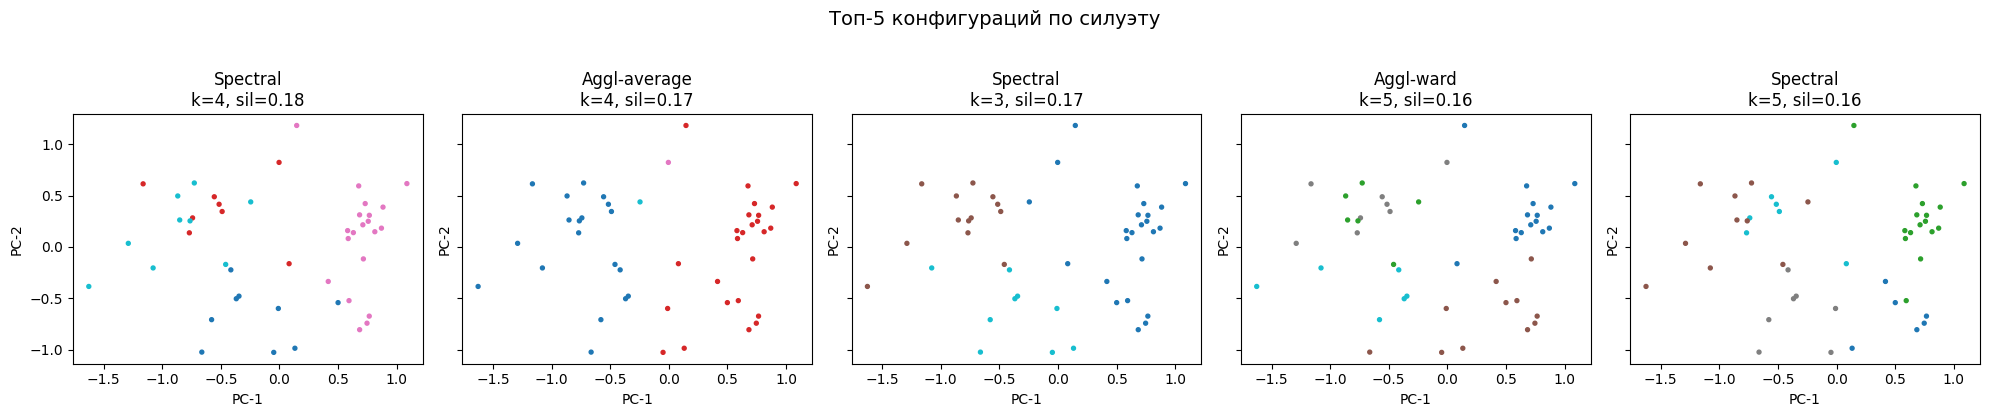

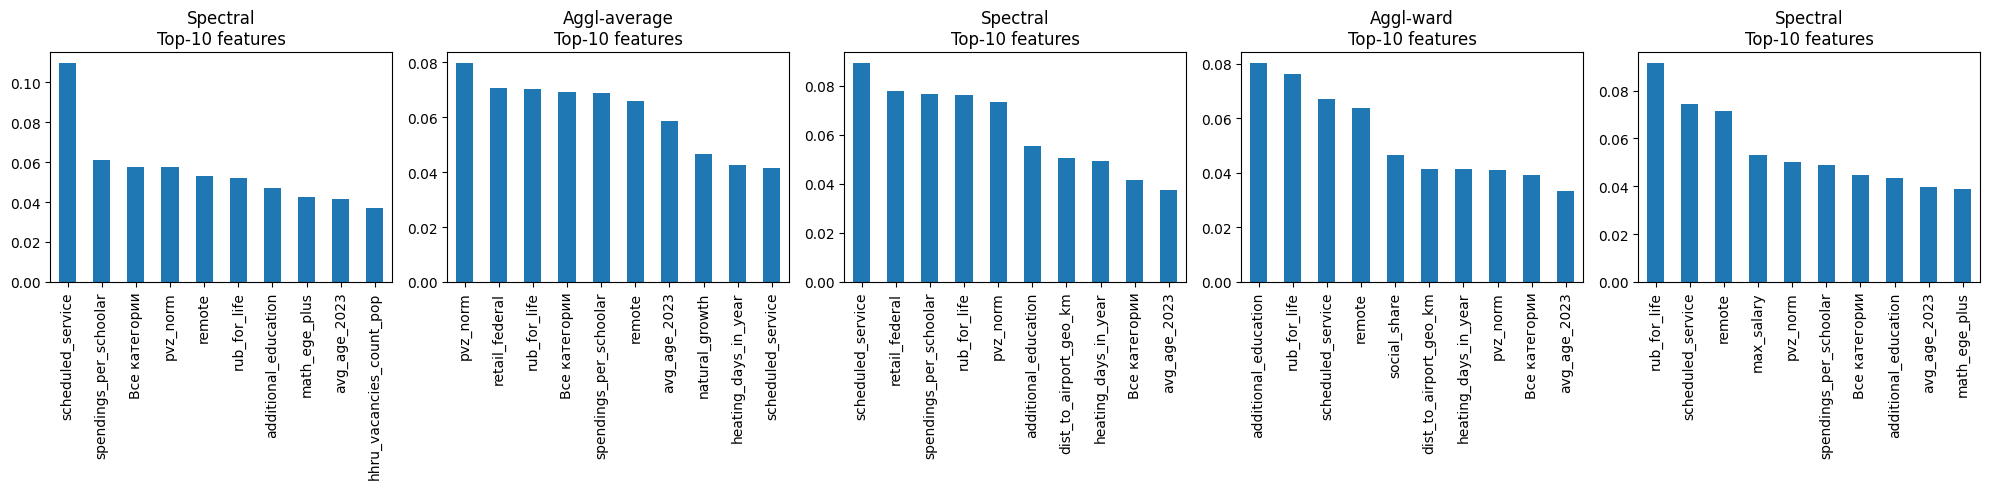


Silhouette на top-20 признаках = 0.249 (базовый = 0.180)


cluster
1    20
0    10
2     8
3     8
Name: count, dtype: int64

In [115]:
"""
k ≥ 3, без K-means, 8 алгоритмов: GMM / Aggl-avg / Aggl-ward /
Spectral / Birch / OPTICS / Affinity / HDBSCAN
"""

df = data[features]
num_cols = df.columns.tolist()

preprocess = Pipeline([
    ('imp',   SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler())
])
X_full = preprocess.fit_transform(df)

pca = PCA(n_components=0.9, svd_solver='full', random_state=42)
X_pca = pca.fit_transform(X_full)

def evaluate(labels, X):
    """silhouette, Davies–Bouldin (для точек без шума)"""
    mask = labels != -1
    if mask.sum() < 2 or len(np.unique(labels[mask])) < 2:
        return None, None
    return (silhouette_score(X[mask], labels[mask]),
            davies_bouldin_score(X[mask], labels[mask]))

def try_gmm(k, X):
    mdl = GaussianMixture(n_components=k, random_state=42, n_init=2)
    labels = mdl.fit_predict(X)
    sil, db = evaluate(labels, X)
    return _pack('GMM', k, sil, db, labels, mdl)

def try_aggl(k, X, linkage):
    mdl = AgglomerativeClustering(n_clusters=k, linkage=linkage)
    labels = mdl.fit_predict(X)
    sil, db = evaluate(labels, X)
    return _pack(f'Aggl-{linkage}', k, sil, db, labels, mdl)

def try_spectral(k, X):
    mdl = SpectralClustering(n_clusters=k, affinity='nearest_neighbors',
                             random_state=42)
    labels = mdl.fit_predict(X)
    sil, db = evaluate(labels, X)
    return _pack('Spectral', k, sil, db, labels, mdl)

def try_birch(k, X):
    mdl = Birch(n_clusters=k)
    labels = mdl.fit_predict(X)
    sil, db = evaluate(labels, X)
    return _pack('Birch', k, sil, db, labels, mdl)

def try_optics(min_s, xi, X):
    mdl = OPTICS(min_samples=min_s, xi=xi)
    labels = mdl.fit_predict(X)
    k = len(np.unique(labels[labels != -1]))
    sil, db = evaluate(labels, X)
    return _pack('OPTICS', k, sil, db, labels, mdl)

def try_affinity(X, pref):
    mdl = AffinityPropagation(preference=pref, random_state=42)
    labels = mdl.fit_predict(X)
    k = len(np.unique(labels))
    sil, db = evaluate(labels, X)
    return _pack('Affinity', k, sil, db, labels, mdl)

def try_hdb(X, min_cl):
    if not HDBSCAN_AVAILABLE:
        return None
    mdl = hdbscan.HDBSCAN(min_cluster_size=min_cl)
    labels = mdl.fit_predict(X)
    k = len(np.unique(labels[labels != -1]))
    sil, db = evaluate(labels, X)
    return _pack('HDBSCAN', k, sil, db, labels, mdl)

def _pack(algo, k, sil, db, labels, model):
    if sil is None or k < 2:
        return None
    return {'algo':algo, 'k':k, 'sil':sil, 'db':db,
            'labels':labels, 'model':model}

results = []
K_MIN, K_MAX = 3, 5
for k in range(K_MIN, K_MAX+1):
    results.extend([
        try_gmm(k, X_pca),
        try_aggl(k, X_pca, 'average'),
        try_aggl(k, X_pca, 'ward'),
        try_spectral(k, X_pca),
        try_birch(k, X_pca)
    ])

df_res = (pd.DataFrame(r for r in results if r is not None)
            .sort_values('sil', ascending=False)
            .reset_index(drop=True))

print("\nТОП-10 конфигураций по силуэту:")
print(df_res.head(10)[['algo','k','sil','db']])

TOP_N = 5
top_rows = df_res.head(TOP_N)

fig1, axes1 = plt.subplots(1, TOP_N, figsize=(4*TOP_N, 4),
                           sharex=True, sharey=True)
fig2, axes2 = plt.subplots(1, TOP_N, figsize=(4*TOP_N, 5))

for idx, (row, ax_scat, ax_bar) in enumerate(zip(top_rows.itertuples(),
                                                 axes1, axes2)):
    labels = row.labels
    # scatter
    ax_scat.scatter(X_pca[:,0], X_pca[:,1], s=8, c=labels, cmap='tab10')
    ax_scat.set_title(f"{row.algo}\nk={row.k}, sil={row.sil:.2f}")
    ax_scat.set_xlabel('PC-1'); ax_scat.set_ylabel('PC-2')

    # feature importance
    rf = RandomForestClassifier(n_estimators=400, random_state=42)
    rf.fit(X_full, labels)
    rf_imp = (pd.Series(rf.feature_importances_, index=num_cols)
                .sort_values(ascending=False).head(10))
    rf_imp.plot.bar(ax=ax_bar)
    ax_bar.set_title(f"{row.algo}\nTop-10 features")
    ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=90)

fig1.suptitle('Топ-5 конфигураций по силуэту', y=1.03, fontsize=14)
fig1.tight_layout()
fig2.tight_layout()
plt.show()

# ————————————————————————————————————————————————————————————————
# 6.  Экспорт (лучшая конфигурация → ядро признаков)
best = df_res.iloc[0]
labels_best = best.labels

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_full, labels_best)
rf_imp = pd.Series(rf.feature_importances_, index=num_cols)

TOP_N_RF = 20
TOP_RF_COLS = rf_imp.sort_values(ascending=False).head(TOP_N_RF).index

preprocess_core = Pipeline([
    ('imp',   SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler())
])
X_core = preprocess_core.fit_transform(df[TOP_RF_COLS])

# кластеризация ядра тем же алгоритмом, что «best»
algo = best.algo.split('-')[0]          # убираем суффиксы типа Aggl-ward
if   algo == 'GMM':
    core_mdl = GaussianMixture(n_components=best.k,
                               random_state=42).fit(X_core)
    core_labels = core_mdl.predict(X_core)
elif algo == 'Aggl':
    linkage = 'average' if 'average' in best.algo else 'ward'
    core_mdl = AgglomerativeClustering(n_clusters=best.k,
                                       linkage=linkage).fit(X_core)
    core_labels = core_mdl.labels_
elif algo == 'Spectral':
    core_mdl = SpectralClustering(n_clusters=best.k,
                                  affinity='nearest_neighbors',
                                  random_state=42).fit(X_core)
    core_labels = core_mdl.labels_
elif algo == 'Birch':
    core_mdl = Birch(n_clusters=best.k).fit(X_core)
    core_labels = core_mdl.labels_
elif algo == 'OPTICS':
    core_mdl = OPTICS(min_samples=4, xi=0.05).fit(X_core)
    core_labels = core_mdl.labels_
elif algo == 'Affinity':
    core_mdl = AffinityPropagation(preference=-50,
                                   random_state=42).fit(X_core)
    core_labels = core_mdl.labels_
else:                                   # HDBSCAN
    core_mdl = hdbscan.HDBSCAN(min_cluster_size=50).fit(X_core)
    core_labels = core_mdl.labels_

mask = core_labels != -1
core_sil = silhouette_score(X_core[mask], core_labels[mask])
print(f"\nSilhouette на top-{TOP_N_RF} признаках = {core_sil:.3f} "
      f"(базовый = {best.sil:.3f})")

df_out = df.copy()
df_out['cluster'] = core_labels
# df_out.to_csv("anketa_with_clusters.csv", index=False)
# print('✓ anketa_with_clusters.csv сохранён.')
df_out['cluster'].value_counts()

In [95]:
len(features)

31

In [96]:
TOP_RF_COLS

Index(['scheduled_service', 'pvz_norm', 'rub_for_life', 'Все категории',
       'spendings_per_schoolar', 'remote', 'dist_to_airport_geo_km',
       'math_ege_plus', 'avg_age_2023', 'additional_education',
       'hhru_vacancies_count_pop', 'natural_growth', 'space_per_capita',
       'heating_days_in_year', 'POI_num', 'pop_men_share', 'emissions_all',
       'pop_total', 'vacancies', 'retail_federal'],
      dtype='object')

In [97]:
data['cluster'] = df_out['cluster']
data[['settlement_name_sep','cluster']].sort_values(by = 'cluster')

,settlement_name_sep,cluster
5,село Хатанга (Красноярский край),0
31,пгт Угольные Копи (Чукотский автономный округ),0
45,село Мужи (Ямало-Ненецкий автономный округ),0
44,село Яр-Сале (Ямало-Ненецкий автономный округ),0
36,село Красноселькуп (Ямало-Ненецкий автономный ...,0
34,пгт Эгвекинот (Чукотский автономный округ),0
33,пгт Провидения (Чукотский автономный округ),0
32,пгт Беринговский (Чукотский автономный округ),0
43,поселок Тазовский (Ямало-Ненецкий автономный о...,0
42,село Гыда (Ямало-Ненецкий автономный округ),0


In [98]:
round(data.groupby(by='cluster')[['2023migration_women', '2023migration_men', 'sale_house_count']].mean(), 2)

,2023migration_women,2023migration_men,sale_house_count
cluster,,,
0,-1.00,-14.30,4.00
1,33.55,-12.25,6.65
2,0.38,1.62,2.12
3,-66.62,-253.25,6.50


In [63]:
numeric_cols = data.select_dtypes(include=['number']).columns
corrs = data[numeric_cols].corrwith(data['2023migration_men'])
sorted_feats = corrs.abs().sort_values(ascending=False).index
for feat in sorted_feats:
    print(f"{feat} - {corrs[feat]:.2f}")

2023migration_men - 1.00
2023migration_women - 0.75
Добыча полезных ископаемых - -0.67
2023plus_avg_age_men - -0.57
Административная деятельность - -0.48
rub_for_life - -0.48
Все отрасли - -0.47
ИТ и связь - -0.47
pop_men_rosstat_2023 - -0.47
Услуги ЖКХ - -0.47
Строительство - -0.46
Научная и проф. деятельность - -0.45
pop_total_rosstat_2023 - -0.45
pop_men_rosstat_2024 - -0.45
Гостиницы и общепит - -0.44
wage_average - -0.44
pop_total_rosstat_2024 - -0.44
pop_women_rosstat_2023 - -0.43
Общественное питание - -0.43
pop_women_rosstat_2024 - -0.42
additional_education - 0.40
Обрабатывающие производства - -0.38
Прочие услуги - -0.38
Маркетплейсы - -0.37
dist_to_airport_geo_km - -0.34
2023minus_avg_age_men - -0.34
min_salary - -0.34
Транспортировка и хранение - -0.34
ecology_projects - -0.33
Операции с недвижимостью - -0.33
sport_gym - -0.33
math_oge - -0.32
math_ege_base - -0.32
social_share - 0.32
math_ege_plus - -0.31
hhru_vacancies_count - -0.30
pop_men_share - -0.29
max_salary - -0.27

In [99]:
data.to_excel('data/made/clustered.xlsx', index = False)